# Requirements

In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os

# Loading Models

In [2]:
IMAGE_ADDRESS = os.path.join("images", "image1.jpg")
YOLO_WEIGHT = os.path.join("models", "yolov3.weights")
YOLO_CONFIG_PATH = os.path.join("models", "yolov3.cfg")
YOLO_LABELES_PATH = os.path.join("models", "coco.names")
CONFIDENCE = 0.5
THRESHOLD = 0.3

# load our YOLO object detector trained on COCO dataset (80 classes)
net = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_PATH, YOLO_WEIGHT)
LABELS = open(YOLO_LABELES_PATH).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# Loading Image

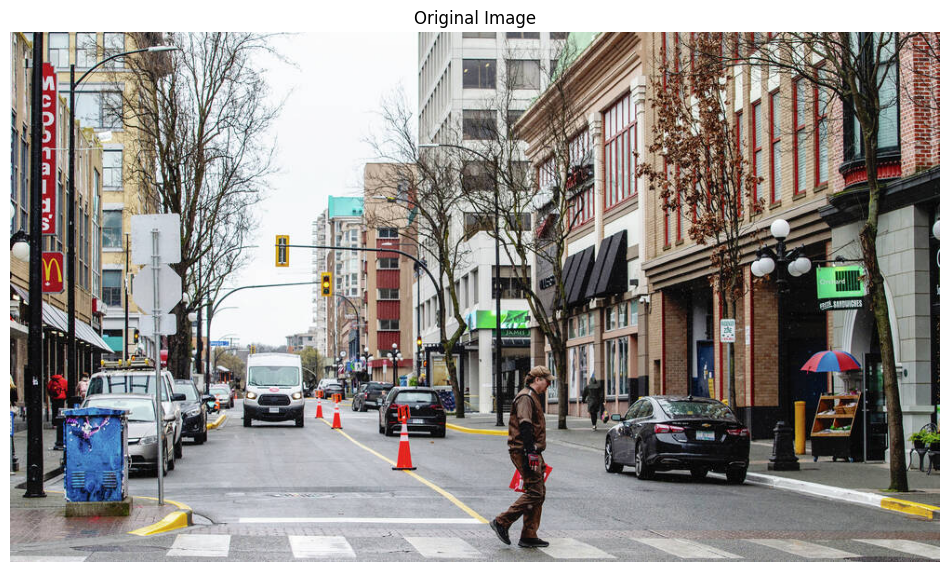

In [3]:
# Load our input image from the specified address
image = cv2.imread(IMAGE_ADDRESS)

# Convert the image from RGB to BGR color space (OpenCV uses BGR by default)
# Note: cv2.imread already loads in BGR format, but if we need RGB we would use cv2.cvtColor
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Grab the spatial dimensions (height and width) of the image
H, W = image.shape[:2]

# Display Original Image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Object Detection Function

In [4]:
def YOLO(image, net):
    # Get the names of all the layers in the network
    ln = net.getLayerNames()
    # Get the names of the output layers (those layers that produce the final predictions)
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    # Construct a blob from the input image and perform mean subtraction, scaling, and channel swapping
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    # Set the blob as input to the network
    net.setInput(blob)
    
    # Perform a forward pass through the network to get the output predictions
    layerOutputs = net.forward(ln)

    # Initialize lists to store the bounding boxes, confidences, and class IDs of the detected objects
    boxes = []
    confidences = []
    classIDs = []

    # Loop over each of the layer outputs
    for output in layerOutputs:
        # Loop over each detection in the output
        for detection in output:
            # Extract the scores for each class and find the class ID with the highest score
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            # Filter out weak predictions by ensuring the confidence is greater than the threshold
            if confidence > CONFIDENCE:
                # Scale the bounding box coordinates back to the size of the original image
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                # Use the center coordinates to derive the top-left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                # Update the lists of bounding box coordinates, confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)

    # Ensure at least one detection exists
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():
            # Extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            # Draw the bounding box rectangle and label on the image
            # Get the color for the current object's bounding box and label
            # The color is obtained from the COLORS array using the object's class ID
            color = [int(c) for c in COLORS[classIDs[i]]]

            # Draw a rectangle around the detected object on the image
            # The rectangle is defined by the top-left corner (x, y) and the bottom-right corner (x + w, y + h)
            # The color and thickness of the rectangle are specified
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

            # Prepare the text label to display the object's class and confidence score
            # The label is formatted to include the class name and confidence score with four decimal places
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])

            # Draw the text label on the image above the bounding box
            # The text is placed at the position (x, y - 5) with the specified font type, size, color, and thickness
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Return the output image with the drawn bounding boxes and labels
    return image

# Visualizing the Result

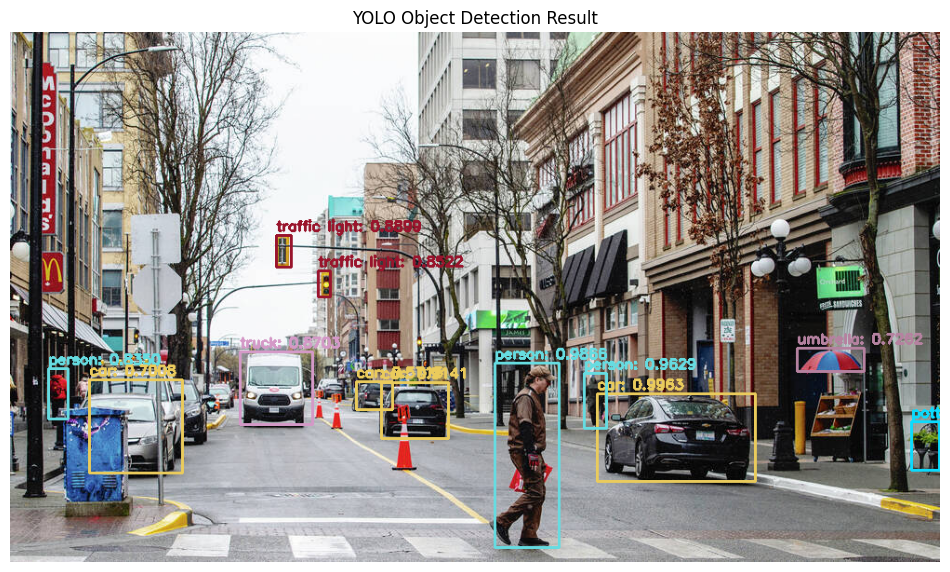

In [5]:
# Detect objects of the image
result = YOLO(image, net)

# Display the result image with detected objects
plt.figure(figsize=(12, 8))
plt.imshow(result)
plt.title("YOLO Object Detection Result")
plt.axis('off')
plt.show()

# YOLO Object Detection Project

## Overview
This project implements real-time object detection using the YOLO (You Only Look Once) v3 algorithm. The system can identify and locate multiple objects in images simultaneously, drawing bounding boxes around detected objects with their corresponding class labels and confidence scores.

## Key Features
- **Multi-object Detection**: Detects up to 80 different object classes from the COCO dataset
- **Real-time Processing**: Fast inference using OpenCV's DNN module
- **Visual Output**: Displays bounding boxes with class labels and confidence scores
- **Non-Maximum Suppression**: Eliminates duplicate detections for cleaner results

## How It Works
1. **Model Loading**: Loads pre-trained YOLOv3 weights, configuration, and class labels
2. **Image Preprocessing**: Converts input image to blob format suitable for neural network
3. **Forward Pass**: Runs the image through the YOLO network to get predictions
4. **Post-processing**: 
    - Filters detections based on confidence threshold (0.5)
    - Applies Non-Maximum Suppression to remove overlapping boxes
    - Draws bounding boxes and labels on the original image

## Technical Details
- **Model**: YOLOv3 trained on COCO dataset (80 classes)
- **Input Size**: 416x416 pixels
- **Confidence Threshold**: 0.5
- **NMS Threshold**: 0.3
- **Classes**: Person, car, bicycle, dog, cat, and 75 other common objects

## Output
The system produces an annotated image showing:
- Colored bounding boxes around detected objects
- Class names (e.g., "person", "car", "dog")
- Confidence scores for each detection
- Different colors for different object classes